<h2> Predicting PGA Rank with Machine Learning </h2>

<p> <img class="img-fluid" alt="Responsive image"  src="https://picsum.photos/1200/200/?image=46"></p>

<p>

In this post we will take the pga stats data found on [pga.com](https://www.pgatour.com/stats.html) and use a Random Forrest model to predict the 2018 PGA Ranks by training our algorithm on previous year data.  We will then explore the feature importance to better understand what metrics were important in predicting rank. 

Sections:
* Python Packages 
* The Data
* Data Preperation
* Train Test Split
* Machine Learning Model
* Summary


</p>

<p> <img class="img-fluid" alt="Responsive image" src="https://i.imgur.com/2QrBEt0.png"></p>&#10;<p>

<p>
Before we begin let's discuss what we are predicting.  If you go to [pga all around ranking](https://www.pgatour.com/stats/stat.127.html) page you'll see column for "Total". The lower the value the better the rank and vice versa.  This is the value we will be trying to predict.  Since "Total" is a continous output we should use a "Regession Model".
</p>

<h3> Packages </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re
import my_utils


%matplotlib inline

<p> 
For this project we will be using [scikit-learn](https://scikit-learn.org/) which is a machine learning library for Python.  Instead of importing the entire package we grab the model "RandomForestRegressor" and the two scoring metrics that we need.  We also are importing a package called my_utils wich contains some custom functions I wrote to assist in the project.  
</p>



<h3> The Data </h3>

In [2]:
my_utils.extract_pga_data()
my_utils.transform_pga_data()

<p>
If you go to [pga/stats](https://www.pgatour.com/stats.html) you'll notice the data isn't all in one place for us to grab and throw into our algortithm.  This is a typical issue with machine learning and you'll find that most of your time is spent wrangling the data vs actually training the algorithm.  

The my_utils.extract_pga_data() function extracts all the tables found on pga.com and then the my_utils.transform_pga_data() takes those tables and combines them into a single table and exports it into a file called "pga_stats.csv". I'll make a post in the future to cover both these functions.

<p>

In [3]:
df = pd.read_csv('pga_stats.csv', low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17648 entries, 0 to 17647
Columns: 1168 entries, Player Name to SG_Putting_TOTAL PUTTS GAINED
dtypes: float64(998), int64(1), object(169)
memory usage: 157.3+ MB


In [5]:
df.head(3)

,Player Name,GIR_Percentage_from_Fairway_ROUNDS,GIR_Percentage_from_Fairway_%,GIR_Percentage_from_Fairway_GREENS HIT,GIR_Percentage_from_Fairway_# OF HOLES,Greens_in_Regulation_Percentage_ROUNDS,Greens_in_Regulation_Percentage_%,Greens_in_Regulation_Percentage_GREENS HIT,Greens_in_Regulation_Percentage_# HOLES,Greens_in_Regulation_Percentage_RELATIVE/PAR,...,Left_Tendency_%,Left_Tendency_NUMBER OF TIMES,Left_Tendency_ATTEMPTS,Left_Tendency_AVG RTP SCORE,Right_Tendency_EVENTS,Right_Tendency_%,Right_Tendency_NUMBER OF TIMES,Right_Tendency_ATTEMPTS,Right_Tendency_AVG RTP SCORE,SG_Putting_TOTAL PUTTS GAINED
0,Fred Couples,71.0,84.14,467.0,555.0,71.0,71.13,845.0,1188.0,-0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tiger Woods,82.0,82.08,591.0,720.0,82.0,75.15,974.0,1296.0,-0.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Stewart Cink,98.0,80.67,651.0,807.0,98.0,69.11,1132.0,1638.0,-0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<p>
Above we import the "pga_stats.csv" which was created when we ran "my_utils.transform_pga_data()".  The dataframe it produces contains over 1,168 columns(featues).  We could do some dimensionality reduction such as PCA but for now we'll leave it be.  Before we start optimizing our model we first need a benchmark result.  
</p>

<h3> Data Preparation </h3>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17648 entries, 0 to 17647
Columns: 1168 entries, Player Name to SG_Putting_TOTAL PUTTS GAINED
dtypes: float64(998), int64(1), object(169)
memory usage: 157.3+ MB


In [7]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 16679341'

<p>
Unfortunately we can't just feed the data as is to our model.  The random forest algorithm can only handle non null numeric values.  We currently have both null values and 169 non numeric columns(object).
</p>

In [8]:
df = df.dropna(thresh=1000)
df = df.dropna(thresh=1500, axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 2661 to 16824
Columns: 1136 entries, Player Name to Right_Tendency_AVG RTP SCORE
dtypes: float64(967), int64(1), object(168)
memory usage: 24.7+ MB


In [10]:
f'Null Values: {df.isna().sum().sum()}'

'Null Values: 97374'

<p>
Pandas makes it very easy to drop null rows or columns.  Above we do both.  The first line drops all rows that don't have at least 1,000 non null values and then again for all columns that do not have at least 1,500 non null values.  
</p>

In [11]:
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(my_utils.make_numeric)
df.loc[:,df.dtypes == object] = df.loc[:,df.dtypes == object].applymap(lambda df:  0 if df=='E' else df)

<p>
We now need to handle the non numeric values.  We could just decide to remove these columns but instead let's try and force as many values as possible such as " 6'11'' " into a numeric values "6.11".  Finally there are some values represented as 'E'.  I assume that stands for even par so I converted them to 0.  
</p>

In [12]:
df = df.fillna(df.mean())

players = df.loc[:,'Player Name']
df = df.drop('Player Name', axis=1)

# Drop Object Columns that did not convert
df = df.drop(df.loc[:,df.dtypes == object], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 2661 to 16824
Columns: 1133 entries, GIR_Percentage_from_Fairway_ROUNDS to Right_Tendency_AVG RTP SCORE
dtypes: float64(1132), int64(1)
memory usage: 24.7 MB


In [14]:
f'Null Values: {df.isna().sum().max()}'

'Null Values: 0'

The last step we need to do if fill the null values.  I used the mean for each column but it may be worth testing other values to see if it improves the result of the algorithm.  Before we remove the object columns that didn't convert to a numeric value we need to save the "Player Name" column in a seperate dataframe.  We will be joining this data back to our final results later on.

<h3> Train Test Split </h3>

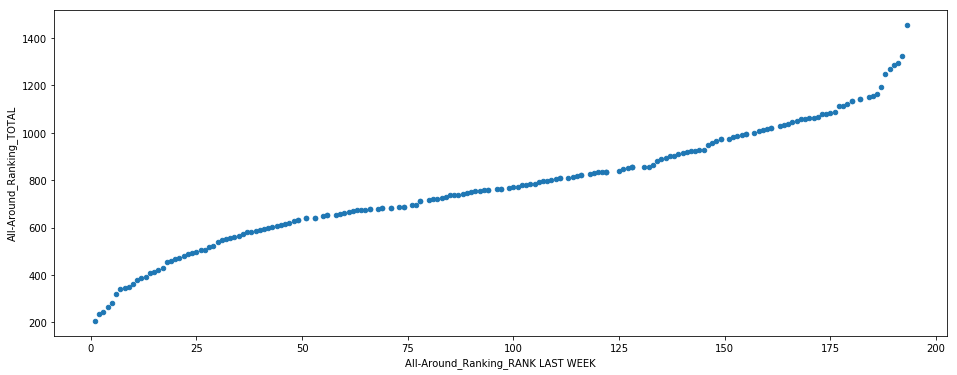

In [15]:
ranking = pd.read_csv(r'data/2018/POINTSRANKINGS/All-Around_Ranking.csv')
ranking['All-Around_Ranking_RANK LAST WEEK'] = ranking['All-Around_Ranking_RANK LAST WEEK'].str.replace('T','').map(int)
ranking.plot(kind='scatter', x='All-Around_Ranking_RANK LAST WEEK', y='All-Around_Ranking_TOTAL', figsize=(16,6));

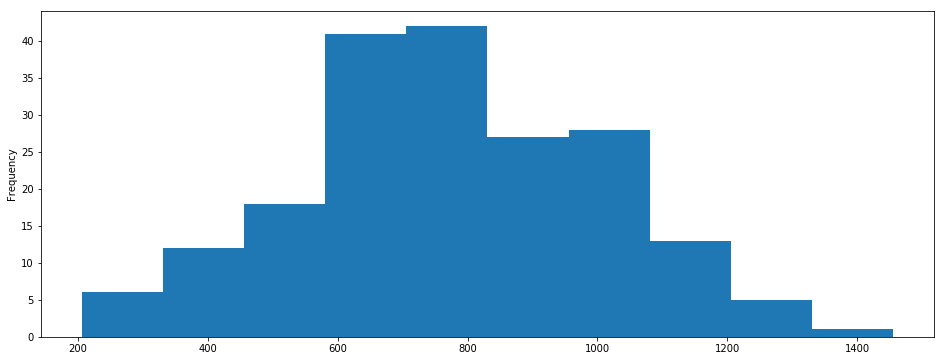

In [16]:
ranking['All-Around_Ranking_TOTAL'].plot(kind='hist', figsize=(16,6));

Before we do our final data prep for our model let's look one last time at our target variable ('Ranking Total').  This gives us a good idea of the distribution of the values we are trying to predict.

In [17]:
target = df[['All-Around_Ranking_TOTAL', 'Year']]

In [18]:
feature = df.drop('All-Around_Ranking_TOTAL', axis=1)

In [19]:
feature_train = feature[~feature['Year'].isin([2018])]
target_train = target[~target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

feature_test = feature[feature['Year'].isin([2018])]
target_test = target[target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

The machine learning algorithm takes two datasets.  One is the features that describe the target (pga rank) and the other is the actual target.  Above we create two new dataframes with one containing only the Target and the other containing only the Features.

Finally we need to create a [cross-validation](https://scikit-learn.org/0.18/modules/cross_validation.html#cross-validation) which is used to evaluate the model.  We train the model on a training set of data and then test it on a testing set of data.  The training data will be pga stat data before the year 2018 and the test data will be 2018.

<h3> Machine Learning Model </h3>

In [20]:
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rfr.fit(feature_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Now that are data is ready we initialize our [Random Forest Regressor model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) by calling the class we imported earlier.  Most of the default parameters are good enough but we'll go ahead and change the number of decision trees to 50 (n_estimators).  We then fit the model using our training data.  We simply call "fit" and pass the feature and target training data as parameters.

In [21]:
target_predict = rfr.predict(feature_test)

In [22]:
print('Random Forest Results:')
print(f'R Squared: {r2_score(target_test, target_predict)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(target_test, target_predict))}')

Random Forest Results:
R Squared: 0.7852457758785075
Root Mean Squared Error: 109.82144907858486


In [23]:
target_mean = target_test.map(lambda x: target_test.mean())  

In [24]:
print('Mean Model Results:')
print(f'R Squared: {r2_score(target_test, target_mean)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(target_test, target_mean))}')

Mean Model Results:
R Squared: 0.0
Root Mean Squared Error: 236.98251948756112


Now that we have a trained model we can use the predict method on the feature_test data to generate some predictions for 2018 Rank.  We save the results in a variable called "target_predict".

To evaluate our results we calculate the [R-Squared](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) and [Root Mean Squared Error](https://www.statisticshowto.datasciencecentral.com/rmse/) values.  A perfect R-Squared would be 1 and a perfect Root Mean Squared Error would be 0.  Our initial results of 0.78 for R Squared and 109 for RMSE.  Above I also calculated the R-Squared and Root Mean Squared Error for a simple model that just takes the mean.  Given that R Squared indicates how much better we did than the mean it is of course 0 and the RMSE is 236.9.  I find it very helpful to have some perspective on our scoring metrics.

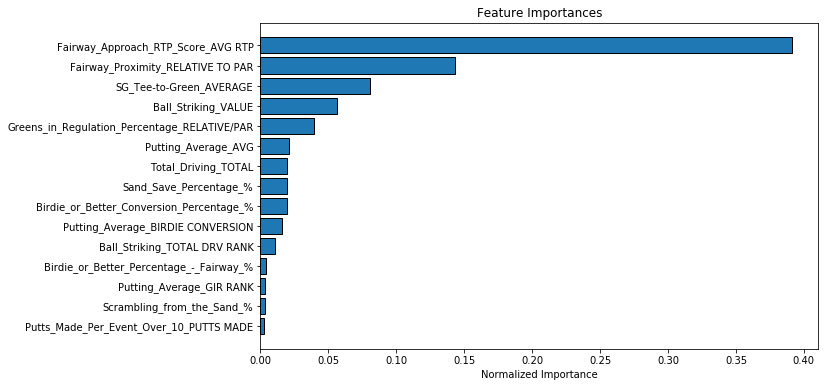

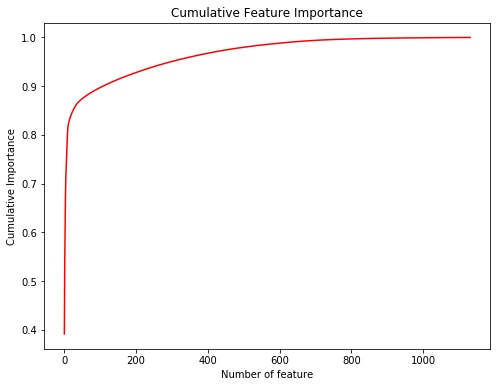

5 feature required for 0.70 of cumulative importance


In [25]:
feature_importance_df = pd.DataFrame({'feature': feature_train.columns, 'importance': rfr.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
my_utils.plot_feature_importances(feature_importance_df, table=False)

Unfortunately I suspect that our algorithm is cheating a bit as there are probably features in our dataset that relate to scoring/rank which are used to calculate rank.  Above I explore the feature importance which our model provides and as you can see there are quite a few features in our top 10 most important features that are score/rank like features which we don't want since those features are a result of playing well but don't lead to playing well.  Machine learning is an iterative process and you rarely (actually never) will ever just run a model once and be done.  

In [26]:
feature = df[
    df.columns[
        ~df.columns.str.contains('par|rank|rtp|score|birdie|ball_striking|total_driving|rounds|total putts|round|sg:|sg_'
                                 ,case=False)
    ]
]

The above code removes all column names that I found that alluded to some kind of rank or score.  Please keep in mind that it took me a few iteration of running the model before coming up with a final list.  Now that I've removed these features let's re-train the model and run it again.

Random Forest Results:
R Squared: 0.6102923091791346
Root Mean Squared Error: 147.94006346921248


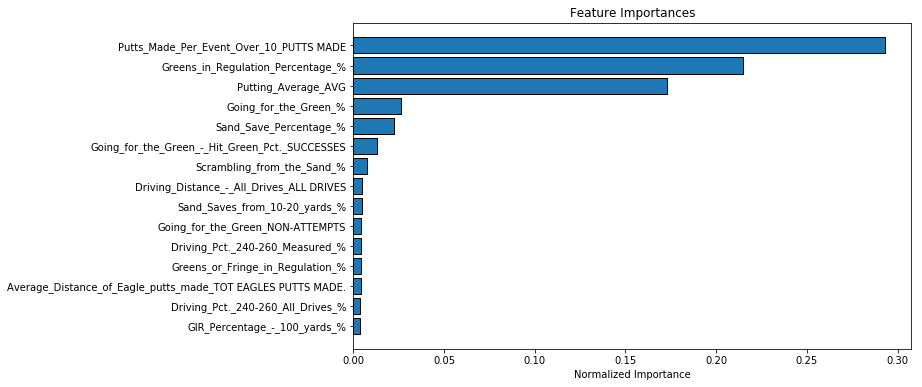

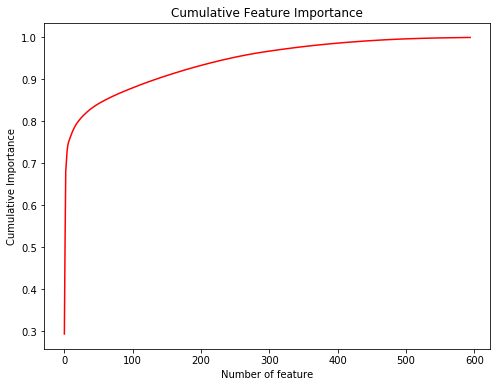

4 feature required for 0.70 of cumulative importance


In [27]:
feature_train = feature[~feature['Year'].isin([2018])]
target_train = target[~target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']
feature_test = feature[feature['Year'].isin([2018])]
target_test = target[target['Year'].isin([2018])]['All-Around_Ranking_TOTAL']

rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rfr.fit(feature_train, target_train)
target_predict = rfr.predict(feature_test)

print('Random Forest Results:')
print(f'R Squared: {r2_score(target_test, target_predict)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(target_test, target_predict))}')

feature_importance_df = pd.DataFrame({'feature': feature_train.columns, 'importance': rfr.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
my_utils.plot_feature_importances(feature_importance_df, table=False)

Alright, that looks pretty good.  We could continue to tweak the parameters and features to try and get a better score but I'm happy with the current results.  Based on the Feature Importance it appears that Putting is indeed the most important aspect of your game and if you can make the long putts consistently you'll be a top ranked player.  Let's now visualize our 2018 predictions.

In [28]:
results = pd.merge(target_test.to_frame(), players.to_frame(), left_index=True, right_index=True, how='left')
results = results.reset_index(drop=True)
results = pd.concat([results, pd.Series(target_predict)], axis=1)
results.columns = ['2018 Rank Score', 'Player Name', '2018 Rank Score Predict']
results[['2018 Rank Score', '2018 Rank Score Predict']] = results[['2018 Rank Score', '2018 Rank Score Predict']].astype(int)
results = results.set_index('Player Name')

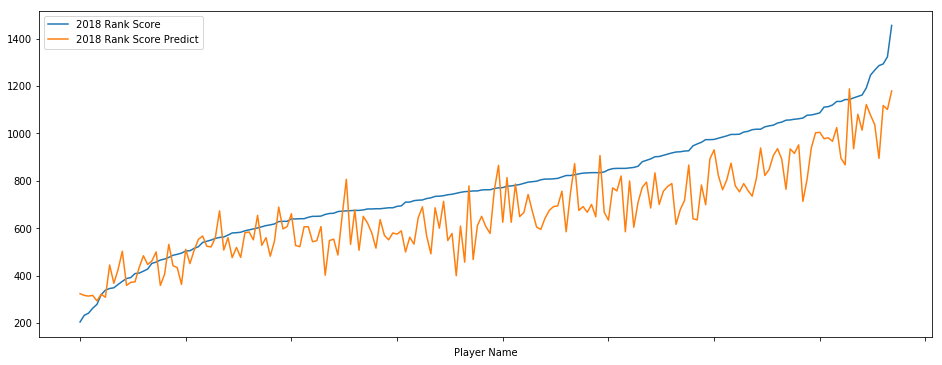

In [29]:
results.sort_values('2018 Rank Score').plot(figsize=(16,6));

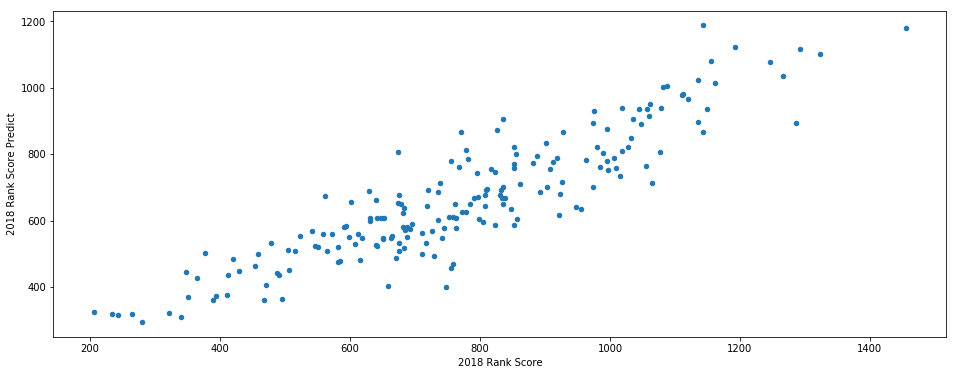

In [30]:
results.sort_values('2018 Rank Score').plot(x='2018 Rank Score', y='2018 Rank Score Predict', kind='scatter', figsize=(16,6));

Above we combine our prediction results with the 2018 actual results.  We then add back the Player Names that we saved earlier in a seperate dataframe.  Finally we plot the predicted results vs the actual results to visualize our accuracy.

In [31]:
results['Error'] = np.abs(results['2018 Rank Score'] - results['2018 Rank Score Predict'])
results.sort_values('2018 Rank Score')
results.sort_values('2018 Rank Score').head(25)

,2018 Rank Score,2018 Rank Score Predict,Error
Player Name,,,
Dustin Johnson,206,325,119
Tommy Fleetwood,234,318,84
Justin Thomas,243,315,72
Rickie Fowler,264,318,54
Justin Rose,280,295,15
Hideki Matsuyama,321,323,2
Brooks Koepka,340,310,30
Rafa Cabrera Bello,347,446,99
Bryson DeChambeau,350,369,19


Our final visualization is a table of the 2018 Rank/Predicted Rank and the Error.  

<h3> Summary </h3>

As you can see machine learning models are not only for predictions.  They can be a powerful tool in exploring data and finding new insights and guiding research.  Without too much effort we created a fairly accurate model and gained an understanding of what aspects of the golf game can increase your peformance....if you were a PGA Player.